In [1]:
%matplotlib inline

In [3]:
from __future__ import division, print_function

import glob
import os
import ConfigParser
import time

import numpy as np
import pylab as plt
from scipy.ndimage.interpolation import shift
import scipy.signal

import errno
import sys
import astra


def mkdir_p(path):
    '''
    Create directory if absent
    '''
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def find_tomo_config(data_root, log_ext='log'):
    """
    Retrun path to logfile in directory
    """
    log_files = glob.glob(os.path.join(data_root, '*.'+log_ext))
    if len(log_files) == 0:
        raise IOError('Config file not found')
    else:
        return log_files[0]
    
def read_config(config_path):
    """
    Parse config, return dictionary
    """
    def as_dict(config):
        d = dict(config._sections)
        for k in d:
            d[k] = dict(config._defaults, **d[k])
            d[k].pop('__name__', None)
        return d

    config = ConfigParser.RawConfigParser()
    config.optionxform = str
    config.read(config_path)
    res = as_dict(config)
    return res

def check_datafiles(data_files, images_ext='tif'):
    '''
    Check that all file in sequence present
    '''
    for idf, df in enumerate(data_files):
        if not '{:04d}.{}'.format(idf, images_ext) in df:
            raise ValueError('!!! File number {} missing. Found {}'.format(idf, df))

def show_cuts(data):
    """
    Show voulume cut in 2 cental slices in ortogonal directions
    """
    plt.figure(figsize=(10,10))
    plt.imshow(data[data.shape[0]//2])
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(data[:,data.shape[1]//2,:])
    plt.colorbar()
    plt.show()

def build_geometry(angles, slices_number, rec_size,  pixel_size, os_distance, ds_distance):
    """
    Build astra circular geometry for square detector.  See example #5 from python samples
    """

#     # All distances in [pixels] (MMC1 dataset configuration)
#     pixel_size = 2.82473e-3
#     os_distance = 56.135 / pixel_size # object-sample distance
#     ds_distance = 225.082 / pixel_size # detector-sample distance
    detector_size = rec_size

    # Circular

    # Parameters: width of detector column, height of detector row, #rows, #columns,
    #             angles, distance source-origin, distance origin-detector

    proj_geom = astra.create_proj_geom('cone', ds_distance / os_distance,ds_distance / os_distance,
                                       slices_number, detector_size, angles,
                                       os_distance, (ds_distance - os_distance))
    return proj_geom

def read_data(config, tmp_dir, images_ext='tif'):
    '''
    Load data from images to memory maped file 'images.tmp' in tmp_dir
    If mmaped file exist - read it
    '''
    
    object_name = config['Acquisition']['Filename Prefix']

    print('Object name:\t', object_name)

    #find projections files
    data_files = glob.glob(os.path.join(raw_dir,object_name+'[0-9]'*4+'.'+images_ext))
    data_files = sorted(data_files)

    print('Data files found:', len(data_files))
    print('First file:', data_files[0])
    print('Last file:', data_files[-1])
    
    check_datafiles(data_files, images_ext=images_ext)
    images_num = len(data_files)
    data_tmp_file = os.path.join(tmp_dir,'images.{}.tmp'.format(images_ext))
    data_tmp_size_file = os.path.join(tmp_dir,'images.{}.size.txt'.format(images_ext))
    if os.path.exists(data_tmp_file) and os.path.exists(data_tmp_size_file):
        print('File {} found, read it. Not load original images'.format(data_tmp_file))
        data_blob = np.memmap(data_tmp_file,
                      dtype='uint16',
                      shape=tuple(np.loadtxt(data_tmp_size_file).astype('uint16')),
                      mode='r+'
                     )
    else:
        data_blob = np.memmap(data_tmp_file,
                      dtype='uint16',
                      shape=(images_num,
                             int(config['Acquisition']['Number of Rows']),
                             int(config['Acquisition']['Number of Columns'])),
                      mode='w+'
                     )
        np.savetxt(data_tmp_size_file, data_blob.shape,fmt='%5u')

        for idf, data_file in enumerate(data_files):
            data_blob[idf] = plt.imread(data_files[idf])
            
    return data_blob

def preprocess_sinogramm(data_blob, tmp_dir):
    '''
    Calculate log from sinogram and normalise each frame to maximum in this frame.
    Save result to mmaped file 'sinogram.tmp' in tmp_dir
    If mmaped file exist - read it
    '''
    
    sinogram_blob_file = os.path.join(tmp_dir,'sinogram.tmp')
    sinogram_blob_size_file = os.path.join(tmp_dir,'sinogram.size.txt')
    sinogram_blob =  np.memmap(sinogram_blob_file,
                  dtype='float32',
                  shape= data_blob.shape,
                  mode='w+'
                 )

    np.savetxt(sinogram_blob_size_file, data_blob.shape,fmt='%5u')

    for im_numb in range(data_blob.shape[0]):
        sinogram_blob[im_numb] = -np.log(data_blob[im_numb].astype('float32')/data_blob[im_numb].max())
            
    return sinogram_blob

def find_start_stop_slices(optical_axis, sinogram_blob):
    '''
    Calculate first and last slice on image based on positin of optical axis
    '''
    if optical_axis <= sinogram_blob.shape[1]//2:
        start_line = sinogram_blob.shape[1] - (optical_axis*2)
        stop_line = sinogram_blob.shape[1]
    else:
        start_line = 0
        stop_line = optical_axis*2
    return start_line, stop_line

def crop_sinogram(sinogram_blob, start_line, stop_line):
    '''
    Crop sinogram so optical axis in the center of the image.
    Save sinogram in format that can be maped (linked) to ASTRA.
    Save result to mmaped file 'sinogram_croped.tmp' in tmp_dir
    If mmaped file exist - read it
    '''
    sinogram_croped_file = os.path.join(tmp_dir,'sinogram_croped.tmp')
    sinogram_croped_size_file = os.path.join(tmp_dir,'sinogram_croped.size.txt')
    sinogram_croped_blob =  np.memmap(sinogram_croped_file,
          dtype='float32',
          shape= (stop_line-start_line,sinogram_blob.shape[0],sinogram_blob.shape[-1]),
          mode='w+'
         )

    np.savetxt(sinogram_croped_size_file, sinogram_blob.shape,fmt='%5u')
    
    for im_numb in range(sinogram_blob.shape[0]):
        sinogram_croped_blob[:,im_numb,:] = sinogram_blob[im_numb, start_line:stop_line, :]

    return sinogram_croped_blob

def bh_inplace_correction(sinogram, percent):
    '''
    Change sinogram according to the value (in percent) for beamhardening correction.
    '''
    for sid in range(sinogram.shape[0]):
        sinogram[sid] = np.power(sinogram[sid], 1.0 + percent / 100.0)

def load_corrections_log(config):
    """
    Loading nRecon thermal shift. Used for testing proposes.
    """
    object_name = config['Acquisition']['Filename Prefix']
    corr_file = os.path.join(raw_dir,object_name+'_TS.crv')
    return np.loadtxt(corr_file, comments=["[", 'C'])

def images_correlation(im1, im2):
    return np.sum(im1*im2)/(np.sum(im1)*np.sum(im2))

def crop_images_correlation(im1, im2, dx, dy, constant=0):
    """
    Shifts the array in two dimensions while setting rolled values to constant
    :param im1: The 2d numpy array
    :param im2: The 2d numpy array 
    :param dx: The shift in x
    :param dy: The shift in y
    :param constant: The constant to replace rolled values with
    :return: The shifted array with "constant" where roll occurs
    """
    t1 =np.array(im1).astype('float32')
    t2 =np.array(im2).asdtype('float32')
    t1 = shift(t1, (dx,dy), order=0)
#     if dx > 0:
#         t1 = t1[dx:, :]
#         t2 = t2[:-dx,:]
#     elif dx < 0:
#         t1 = t1[:dx, :]
#         t2 = t2[-dx:,:]

#     if dy > 0:
#         t1 = t1[:, dy:]
#         t2 = t2[:, :-dy]
#     elif dy < 0:
#         t1 = t1[:, :dy]
#         t2 = t2[:, -dy:]
        
    return images_correlation(t1, t2)

def find_shift(im1,im2):
    search_range = 35
    search_matrix = np.zeros((len(np.arange(-search_range, search_range, 1)),
                             len(np.arange(-search_range, search_range, 1)))
                             )
    for ix, dx in enumerate(np.arange(-search_range, search_range, 1)):
        print(ix)
        for iy, dy in enumerate(np.arange(-search_range, search_range, 1)):
            search_matrix[ix,iy] = crop_images_correlation(im1,im2, dx, dy)
    
    plt.figure()
    plt.imshow(search_matrix, interpolation='nearest')
    plt.show()
    
    shift_vector = np.array(np.unravel_index(np.argmax(search_matrix), search_matrix.shape))*1-search_range
    return shift_vector
    
def cross_image(im1, im2):
    """
    Calculate crosscorreations of images 
    """
    im1_fixed = im1.copy().astype('float32')
    im2_fixed = im2.copy().astype('float32')
 
    # get rid of the averages, otherwise the results are not good
    im1_fixed -= np.mean(im1_fixed)
    im2_fixed -= np.mean(im2_fixed)
 
    # calculate the correlation image; note the flipping of one of the images
    return scipy.signal.fftconvolve(im1_fixed, im2_fixed[::-1,::-1])

def calculate_termal_shift(data_blob, data_corr_blob, config, config_corr):
    data_step = float(config['Acquisition']['Rotation Step (deg)'])
    corr_step = float(config_corr['Acquisition']['Rotation Step (deg)'])
    image_shift = []
    real_angles=[]


    for corr_number in range(data_corr_blob.shape[0]):  # Рассчитаем сдвиги по свем опорным кадрам
        print(corr_number)
        real_angle = int(corr_number*corr_step/data_step)  # calculate number of base frame
        real_angles.append(real_angle)

        data_0 = data_blob[real_angle].astype('float32')  # get data frame
        data_1 = data_corr_blob[corr_number].astype('float32') # get correction frame

#         corr_img = cross_image(data_0, data_1) # find crosscorrelation array

#         shift_vector = np.unravel_index(np.argmax(corr_img), corr_img.shape)  # find position of maximum in 2d array

#         image_shift.append(np.array(corr_img.shape)/2 - np.array(shift_vector))  # add shit to list
        image_shift.append(find_shift(data_0, data_1))
    
        print(image_shift[-1])
#         print(image_shift[-1], -corr_file[real_angle,1],corr_file[real_angle,2])
        
    # This section used for visualization and debuging
    #     corr_file = load_corrections_log(config) # load correlations file for compeare corrected image with nRecon
    #     plt.figure(figsize=(7,7))
    #     plt.imshow(data_0-data_1)
    #     plt.colorbar(orientation='horizontal')
    #     plt.title('No correction')
    #     plt.savefig('no_corr_{}.png'.format(corr_number))
    #     plt.show()

    #     plt.figure(figsize=(7,7))
    #     plt.imshow(shift(data_0, image_shift[-1],order=1) -data_1,vmin=-5000, vmax=5000)
    #     plt.colorbar(orientation='horizontal')
    #     plt.title('My correction')
    #     plt.savefig('my_corr_{}.png'.format(corr_number))
    #     plt.show()

    #     plt.figure(figsize=(7,7))
    #     plt.imshow(shift(data_0, (corr_file[real_angle,2],-corr_file[real_angle,1])) -data_1,vmin=-5000, vmax=5000)
    #     plt.colorbar(orientation='horizontal')
    #     plt.title('nRecon correction')
    #     plt.savefig('nrec_corr_{}.png'.format(corr_number))
    #     plt.show()
    
    image_shift = np.array(image_shift)
    real_angles = np.array(real_angles)
    
#     corr_file = load_corrections_log(config) # load correlations file for compeare corrected image with nRecon
#     plt.figure(figsize=(5,5))
#     plt.plot(corr_file[:,2],-corr_file[:,1],label = 'nRecon')
#     plt.plot(image_shift[:,0],image_shift[:,1], label = 'my')
#     plt.grid(True)
#     plt.legend(loc=0)
#     plt.show()
    
    return image_shift, real_angles
    
def reconstruct(config, sinogram_croped_blob, tmp_dir):
    '''
    Reconstruct using FDK method.
    Result saved to rec.tmp in tmp_dir.
    '''
    astra.astra.set_gpu_index([0,])  #use inly 1 gpu by default
    angles_step = float(config['Acquisition']['Rotation Step (deg)'])

    angles = np.arange(sinogram_croped_blob.shape[1])*angles_step
    angles = angles.astype('float64')/180.*np.pi

    rec_size = sinogram_croped_blob.shape[-1]
    slices_number = sinogram_croped_blob.shape[0]

    pixel_size = float(config['Acquisition']['Image Pixel Size (um)']) *1e-3
    os_distance = float(config['Acquisition']['Object to Source (mm)']) / pixel_size
    ds_distance = float(config['Acquisition']['Camera to Source (mm)']) /pixel_size

    proj_geom = build_geometry(angles, slices_number, rec_size, pixel_size, os_distance, ds_distance)
    # sinogram_id = astra.data3d.create('-sino', proj_geom, np.rollaxis(sinogram_croped_blob,-1))  #fix it

    proj_id = astra.data3d.link('-sino', proj_geom, sinogram_croped_blob)  #fix it


    vol_geom = astra.create_vol_geom((rec_size, rec_size, slices_number))

    rec_volume = np.memmap(os.path.join(tmp_dir,'rec.tmp'),
                                dtype='float32', mode='w+', 
                                shape=(slices_number,rec_size, rec_size)
                           )
    np.savetxt(os.path.join(tmp_dir,'rec.size.txt'), rec_volume.shape,fmt='%5u')

    rec_id = astra.data3d.link('-vol', vol_geom, rec_volume)

     # Set up the parameters for a reconstruction algorithm using the GPU
    # Complete list of suporteed algoritms can be found http://www.astra-toolbox.com/docs/algs/index.html

    print('Start reconstruction')
    t=time.time()
    cfg = astra.astra_dict('FDK_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = proj_id
    cfg['option'] = {'ShortScan': True}

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # For FDK number of iterationa my be 1
    astra.algorithm.run(alg_id, 1)

    print('Stop reconstruction')
    print(time.time()-t)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.data3d.info()
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(proj_id)
    astra.data3d.delete(rec_id)
    astra.data3d.clear()
    return rec_volume

def main(raw_dir, tmp_dir, bh_percent=0):
    """
    Main function
    
    :param raw_dir: directory with data files
    :param tmp_dir: directory for memory_maped files
    :param bh_percent:
    """
    mkdir_p(tmp_dir)

    #load tomographic images
    config_file = find_tomo_config(raw_dir)
    config = read_config(config_file)

    data_blob = read_data(config, tmp_dir)

    print(data_blob.shape)

#     load correction images
    config_file_corr = find_tomo_config(raw_dir, log_ext='oog')
    config_corr = read_config(config_file_corr)

    data_corr_blob = read_data(config_corr, tmp_dir, images_ext='iif')
    
#  calculate thermal shift (VERY SLOW NOW)
    image_shift, real_angles = calculate_termal_shift(
        data_blob, data_corr_blob, config, config_corr)

#     #TODO
#     # МЫ должны интерполировать image_shift (ДВУМЕРНЫЙ МАССИВ СДВИГОВ по x и у полученный в точках real_angles)
#     # на весь диапазин наших углов. Потом изображния сдвинуть на полученные значения
    
#     # Заменть data_blob на сдвинутые значения
# #     for db in range(data_blob.shape[0]):
# #         data_blob[db] = fix_termal_drift(data_blob[db], dx, dy)
    
#     # Simple preprocessing images and save sinograms.
#     sinogram_blob = preprocess_sinogramm(data_blob, tmp_dir)
#     del data_blob


#     # Found boders for sinogram, centering  at optical line
#     optical_axis = int(config['Acquisition']['Optical Axis (line)'])
#     start_line, stop_line = find_start_stop_slices(optical_axis, sinogram_blob)

#     #Save centered sinogram in sutable for astra format

#     sinogram_croped_blob = crop_sinogram(sinogram_blob,
#                         start_line, stop_line)  # +-600 To reduce reconstruction time in testing

#     del sinogram_blob

#     #Building ASTRA structures and run reconstruction
#     bh_inplace_correction(sinogram_croped_blob, bh_percent)
#     rec_volume = reconstruct(config, sinogram_croped_blob, tmp_dir)

#     # #for fast reconstruction loading
#     # # rec_volume = np.memmap(os.path.join(tmp_dir,'rec.tmp'),
#     # #                             dtype='float32', mode='r', 
#     # #                             shape=tuple(np.loadtxt(os.path.join(tmp_dir,'rec.size.txt')).astype('uint16'))
#     # #                        )

#     rec_max = np.max(rec_volume)
#     rec_min = np.min(rec_volume)
#     for idata in range(rec_volume.shape[0]):
#         t = rec_volume[idata]
#         plt.imsave(os.path.join(tmp_dir,'rec_{:04d}.png'.format(idata)), t, vmin=rec_min, vmax=rec_max, cmap=plt.cm.gray)

In [8]:
# reading config and images from disk

#set global colormap for show slices
plt.viridis()

raw_dir = '/diskmnt/a/makov/yaivan/MMC_1/Raw/'  #  Directory with raw files
tmp_dir = '/diskmnt/fast/makov/tmp/'  #  Directory for memory maped files

# raw_dir = '/home/ingacheva/_Schlumberger/3D_modeling/Dataset1/Raw'
# tmp_dir = '/diskmnt/fast/makov/tmp_m/'


main(raw_dir, tmp_dir)

Object name:	 MMC1_2.82um_
Data files found: 2029
First file: /diskmnt/a/makov/yaivan/MMC_1/Raw/MMC1_2.82um_0000.tif
Last file: /diskmnt/a/makov/yaivan/MMC_1/Raw/MMC1_2.82um_2028.tif
File /diskmnt/fast/makov/tmp/images.tif.tmp found, read it. Not load original images
(2029, 2096, 4000)
Object name:	 MMC1_2.82um_
Data files found: 25
First file: /diskmnt/a/makov/yaivan/MMC_1/Raw/MMC1_2.82um_0000.iif
Last file: /diskmnt/a/makov/yaivan/MMC_1/Raw/MMC1_2.82um_0024.iif
File /diskmnt/fast/makov/tmp/images.iif.tmp found, read it. Not load original images
0
0


KeyboardInterrupt: 

In [ ]:
# plt.figure(figsize=(7,7))
# plt.imshow(rec_volume[:, :,int(rec_volume.shape[1]/2)])
# plt.show()

In [4]:
x = np.random.randn(2000,4000)

In [7]:
%prun crop_images_correlation(x,x,13,24)

In [71]:
crop_images_correlation(x,x,13,24)

0.0027559476641225043

In [4]:
#set global colormap for show slices
plt.viridis()

raw_dir = '/diskmnt/a/makov/yaivan/MMC_1/Raw/'  #  Directory with raw files
tmp_dir = '/diskmnt/fast/makov/tmp/'  #  Directory for memory maped files

mkdir_p(tmp_dir)

#load tomographic images
config_file = find_tomo_config(raw_dir)
config = read_config(config_file)

data_blob = read_data(config, tmp_dir)

print(data_blob.shape)

#     load correction images
config_file_corr = find_tomo_config(raw_dir, log_ext='oog')
config_corr = read_config(config_file_corr)

data_corr_blob = read_data(config_corr, tmp_dir, images_ext='iif')

Object name:	 MMC1_2.82um_
Data files found: 2029
First file: /diskmnt/a/makov/yaivan/MMC_1/Raw/MMC1_2.82um_0000.tif
Last file: /diskmnt/a/makov/yaivan/MMC_1/Raw/MMC1_2.82um_2028.tif
File /diskmnt/fast/makov/tmp/images.tif.tmp found, read it. Not load original images
(2029, 2096, 4000)
Object name:	 MMC1_2.82um_
Data files found: 25
First file: /diskmnt/a/makov/yaivan/MMC_1/Raw/MMC1_2.82um_0000.iif
Last file: /diskmnt/a/makov/yaivan/MMC_1/Raw/MMC1_2.82um_0024.iif
File /diskmnt/fast/makov/tmp/images.iif.tmp found, read it. Not load original images


In [13]:
data0 = np.array(data_blob[0]).astype('float32')
data1 = np.array(data_corr_blob[0]).astype('float32')

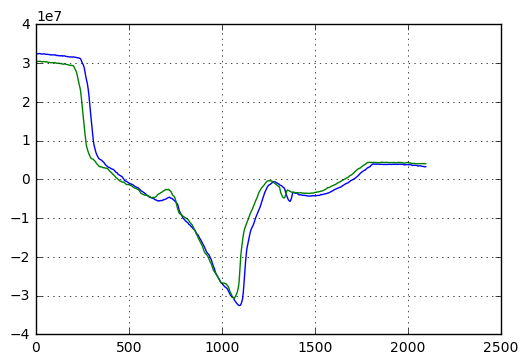

0


In [74]:
p0 = data0.sum(axis=1)
p1 = data1.sum(axis=1)

# xx=np.convolve(p0, p1, mode='full')
# xc = int(len(xx)/2)
# max_pos = np.argmax(xx[xc-100:xc+100])-100

plt.figure()
plt.plot(p0-np.mean(p0))
plt.hold(True)
plt.plot(p1-np.mean(p1))

# plt.plot(xx*1e-12)
plt.grid()
plt.show()
print(max_pos)

In [81]:
res = []
for x in range(-50,50):
    t0 = p0.copy()
    t1 = p1.copy()
    t0=t0-np.mean(t0)
    t1=t1-np.mean(t1)
    t0=np.roll(t0,x)
    t1=np.roll(t1,-x)
    t = np.sum((t0-t1)**2)/np.sum(t0**2)/np.sum(t1**2)
    res.append(t)

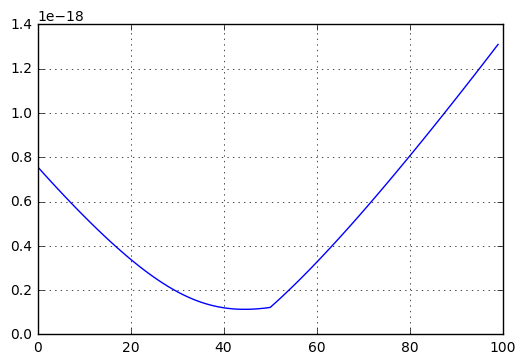

In [82]:
plt.figure()
plt.plot(res)

# plt.plot(xx*1e-12)
plt.grid()
plt.show()

In [24]:
xx=np.convolve(data0.sum(axis=0), data1.sum(axis=0),mode='valid')

In [26]:
from scipy.ndimage import sobel

In [28]:
sd0=sobel(data0)
sd1=sobel(data1)

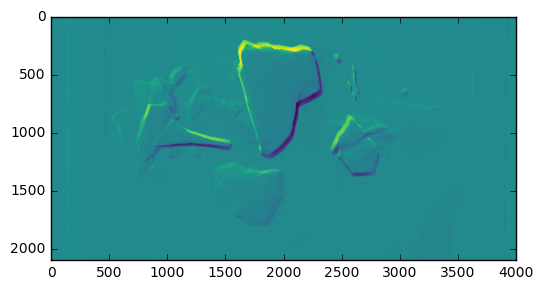

In [6]:
plt.figure()
plt.imshow(data0-data1)
plt.show()

In [7]:
def cm(im):
    t0 = im.sum(axis=0)
    x= np.sum(t0*range(len(t0)))/np.sum(t0)
    t1 = im.sum(axis=1)
    y= np.sum(t1*range(len(t1)))/np.sum(t1)
    return (x,y)

In [30]:
print(cm(sd0))
print(cm(sd1))

(-15462.320058590652, 1085.4580372887565)
(-15703.864199256894, 1079.8527861244188)


In [25]:
cm(data1[500:-500,1500:-1500])

(539.17842468170727, 591.3031948876685)

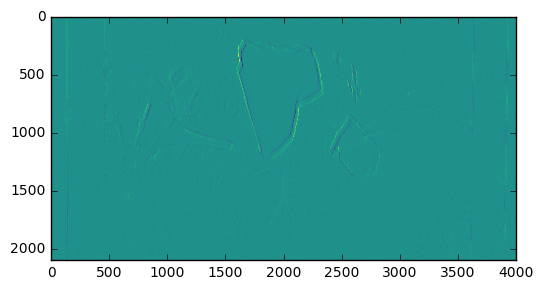

In [32]:
plt.figure()
plt.imshow(sd0-sd1)
plt.show()

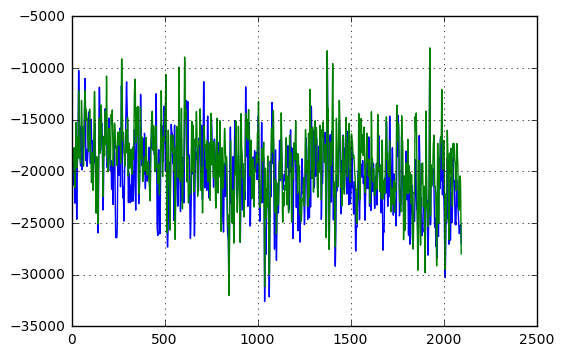

0


In [35]:
p0 = sd0.sum(axis=1)
p1 = sd1.sum(axis=1)

xx=np.convolve(p0, p1, mode='full')
xc = int(len(xx)/2)
max_pos = np.argmax(xx[xc-100:xc+100])-100

plt.figure()
plt.plot(p0)
plt.hold(True)
plt.plot(p1)

# plt.plot(xx*1e-12)
plt.grid()
plt.show()
print(max_pos)

In [38]:
sd0[1,1]

-1762.0

In [68]:
print(load_corrections_log(config).astype('int'))

[[   0   22  -22]
 [   1   21  -22]
 [   2   21  -22]
 ..., 
 [2026    0    0]
 [2027    0    0]
 [2028    0    0]]
